In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr

In [2]:
from ar6_ch6_rcmipfigs import constants

%load_ext autoreload
%autoreload 2

from ar6_ch6_rcmipfigs.constants import INPUT_DATA_DIR

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [3]:
aero_tot = 'aerosol-total'
aero_cld = 'aerosol-cloud_interactions'
aero_rad = 'aerosol-radiation_interactions'
bc_on_snow = 'bc_on_snow'
aero_tot_wbc = 'aerosol-total-with_bc-snow'

In [4]:
first_y = 1750
last_y = 2100

**Set reference year for temperature change:**

In [5]:
ref_year = 2020

## Load data:

In [6]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

PATH_DATASET = OUTPUT_DATA_DIR / 'ERF_data.nc'
PATH_DT_INPUT = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation.nc'
PATH_DT_INPUT_minor = OUTPUT_DATA_DIR / 'dT_data_RCMIP_recommendation_minor.nc'

#PATH_DT_TAB_OUTPUT = RESULTS_DIR / 'tables' / 'table_sens_dT_cs_recommandetion.csv'
PATH_UNCERT_DT_INTPUT = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris.nc'
PATH_UNCERT_DT_OUTPUT = OUTPUT_DATA_DIR / 'dT_uncertainty_data_FaIR_chris_ed02-3.nc'

In [7]:
ds_unc = xr.open_dataset(PATH_UNCERT_DT_INTPUT)

In [8]:
ds_unc

<xarray.Dataset>
Dimensions:      (base_period: 1, scenario: 11, variable: 7, year: 81)
Coordinates:
  * scenario     (scenario) object 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * variable     (variable) object 'HFCs' ... 'total_anthropogenic'
  * year         (year) int64 2020 2021 2022 2023 2024 ... 2097 2098 2099 2100
  * base_period  (base_period) int64 2020
Data variables:
    p05          (scenario, variable, year, base_period) float64 ...
    p16          (scenario, variable, year, base_period) float64 ...
    p50          (scenario, variable, year, base_period) float64 ...
    p84          (scenario, variable, year, base_period) float64 ...
    p95          (scenario, variable, year, base_period) float64 ...
    p05-p50      (scenario, variable, year, base_period) float64 ...
    p16-p50      (scenario, variable, year, base_period) float64 ...
    p50-p50      (scenario, variable, year, base_period) float64 ...
    p84-p50      (scenario, variable, year, base_period) float64 ...
    p95-p50      (scenario, variable, year, base_period) float64 ...

In [9]:
import numpy as np

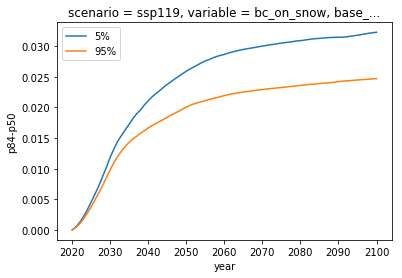

In [10]:
v_sigma2_bot = 'p16-p50'
v_sigma2_top = 'p84-p50'
np.abs(ds_unc[v_sigma2_bot]).sel(scenario='ssp119',variable=bc_on_snow).plot(label='5%')
np.abs(ds_unc[v_sigma2_top]).sel(scenario='ssp119',variable=bc_on_snow).plot(label='95%')
plt.legend()
plt.show()

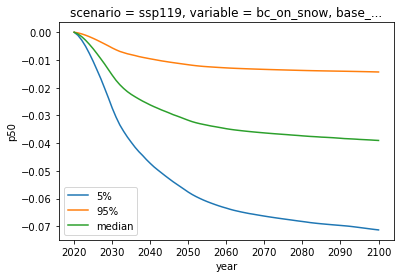

In [11]:
v_sigma2_bot = 'p16'
v_sigma2_top = 'p84'
v_med = 'p50'
ds_unc[v_sigma2_bot].sel(scenario='ssp119',variable=bc_on_snow).plot(label='5%')
ds_unc[v_sigma2_top].sel(scenario='ssp119',variable=bc_on_snow).plot(label='95%')
ds_unc[v_med].sel(scenario='ssp119',variable=bc_on_snow).plot(label='median')
plt.legend()
plt.show()

## plot quantile to quantile



# Compute sigma for bc on snow + aerosol total
We assume that both variables are normally distributed and independent. We estimate the sigma of each of them as

$\sigma_X = (p84_X -p16_X)/2 $

where $p84_X$ and $p16_X$ are the 84th and 16th percentile. 



Let $X$ and $Y$ be independent random variables that are normally distributed (and therefore also jointly so), then their sum is also normally distributed. i.e., if

$X\sim N(\mu_{X},\sigma_{X}^{2})$ 

$Y\sim N(\mu_{Y},\sigma_{Y}^{2})$

and

$Z=X+Y$

then

$Z\sim N(\mu _{X}+\mu _{Y},\sigma _{X}^{2}+\sigma _{Y}^{2})$.

In [12]:
p05 = 'p05'
p95 = 'p95'
p16 = 'p16'

p84 = 'p84'
median = 'p50'
es_sig = 'estimated_sigma'
es_median = 'estimated_median'
ds_unc[es_sig] = np.abs((ds_unc[p16]- ds_unc[p84])/2)

In [13]:
ds_bc_snow = ds_unc.sel(variable=bc_on_snow)
ds_aero_tot = ds_unc.sel(variable=aero_tot)
sigma_sum =np.sqrt(ds_bc_snow[es_sig]**2+ds_aero_tot[es_sig]**2)
median_sum = ds_bc_snow[median] + ds_aero_tot[median]
_coords = ds_bc_snow.coords
_coords['variable'] = [aero_tot_wbc]
ds_sum = xr.Dataset(coords=_coords)#{'variable':[aero_tot_wbc]})
                    #sig_bc_snow.coords)
ds_sum

<xarray.Dataset>
Dimensions:      (base_period: 1, scenario: 11, variable: 1, year: 81)
Coordinates:
  * scenario     (scenario) object 'ssp119' 'ssp126' ... 'ssp534-over' 'ssp585'
  * variable     (variable) <U26 'aerosol-total-with_bc-snow'
  * year         (year) int64 2020 2021 2022 2023 2024 ... 2097 2098 2099 2100
  * base_period  (base_period) int64 2020
Data variables:
    *empty*

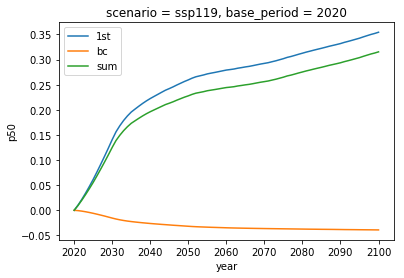

In [14]:
ds_aero_tot['p50'].sel(scenario='ssp119').plot(label='1st')
ds_bc_snow['p50'].sel(scenario='ssp119').plot(label='bc')
median_sum.sel(scenario='ssp119').plot(label='sum')
plt.legend()
plt.show()

In [15]:
from scipy.stats import norm
di = norm(loc=median_sum, scale = sigma_sum)
_p05 =di.ppf(0.05)
_p05.shape
ds_sum[p05] = xr.DataArray(di.ppf(0.05), coords=ds_bc_snow[p05].coords)
ds_sum[p95] = xr.DataArray(di.ppf(0.95), coords=ds_bc_snow[p05].coords)
ds_sum[p16] = xr.DataArray(di.ppf(0.16), coords=ds_bc_snow[p05].coords)
ds_sum[p84] = xr.DataArray(di.ppf(0.84), coords=ds_bc_snow[p05].coords)
ds_sum[median]= xr.DataArray(di.ppf(0.50), coords=ds_bc_snow[p05].coords)

/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [16]:
_sig = ds_aero_tot[es_sig]#.sel(scenario='ssp585')
_med = ds_aero_tot[median]#.sel(scenario='ssp585')

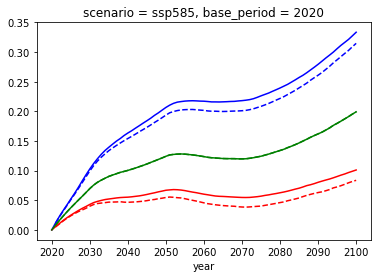

In [17]:
di2 = norm(loc=_med, scale = _sig)
_es_p84 =  xr.DataArray(di2.ppf(0.84), coords=ds_bc_snow[p05].coords)
_es_p16 =  xr.DataArray(di2.ppf(0.16), coords=ds_bc_snow[p05].coords)
_es_med = xr.DataArray(di2.ppf(0.5), coords=ds_bc_snow[p05].coords)
ds_aero_tot['p84'].sel(scenario='ssp585').plot(label='orig', c='b')
_es_p84.sel(scenario='ssp585').plot(label='est', c='b', linestyle='dashed')
ds_aero_tot['p16'].sel(scenario='ssp585').plot(label='orig', c='r')
_es_p16.sel(scenario='ssp585').plot(label='est', c='r', linestyle='dashed')

ds_aero_tot['p50'].sel(scenario='ssp585').plot(label='orig', c='g')
_es_med.sel(scenario='ssp585').plot(label='est', c='g', linestyle='dashed')

plt.show()

In [18]:
for v in [p05, p16, p84, p95, median]:
    ds_sum[f'{v}-{median}'] = ds_sum[v]-ds_sum[median]

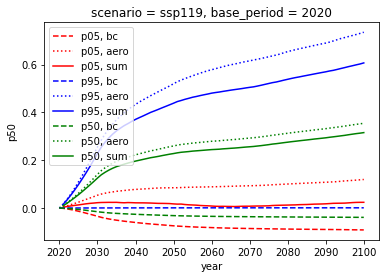

In [19]:
cols = {p05:'r',p95:'b',median:'g'}
for c in [p05, p95, median]:
    ds_bc_snow[c].sel(scenario='ssp119').plot(c=cols[c], label=c+', bc', linestyle='dashed')
    ds_aero_tot[c].sel(scenario='ssp119').plot(c=cols[c], label=c+', aero', linestyle='dotted')
    ds_sum[c].sel(scenario='ssp119').plot(c=cols[c], linestyle='solid', label=c+', sum')

#ds_aero_tot[p95].sel(scenario='ssp119').plot()
#ds_aero_tot[median].sel(scenario='ssp119').plot()
plt.legend()
plt.show()

In [20]:
ds_unc_upd = xr.concat([ds_unc.drop([es_sig]), ds_sum], dim='variable')
ds_unc_upd.variable
ds_unc_upd.to_netcdf(PATH_UNCERT_DT_OUTPUT)

## HFCs
Scale uncertainties to sum of

In [21]:
name_deltaT = 'Delta T'

In [22]:
ds_DT = xr.open_dataset(PATH_DT_INPUT)
ds_DT_minor = xr.open_dataset(PATH_DT_INPUT_minor)

# hfc Delta T
hfc_dT = ds_DT_minor[name_deltaT].sel(percentile='recommendation')

In [23]:
ls = list(ds_DT_minor['variable'].values)
# chocose only those with HFC in them
vars_HFCs = [v for v in ls if 'HFC-' in v]

vars_HFCs

['HFC-134a',
 'HFC-23',
 'HFC-32',
 'HFC-125',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-43-10mee']

In [24]:
len(vars_HFCs)

11

In [25]:
#excluded_HFCs = ['HFC-23','HFC-125','HFC-143a','HFC-227ea','HFC-236fa']
excluded_HFCs = ['HFC-23','HFC-236fa'] #'HFC-125','HFC-227ea','HFC-143a',

In [26]:
final_HFC_vars = [hfc for hfc in vars_HFCs if hfc not in excluded_HFCs]

In [27]:
final_HFC_vars

['HFC-134a',
 'HFC-32',
 'HFC-125',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-43-10mee']

In [28]:
ordered_lifetime_ls = [
'HFC-152a',
'HFC-32',
'HFC-245fa',
'HFC-365mfc',
'HFC-134a',
'HFC-43-10mee',
'HFC-125',
'HFC-227ea',
'HFC-143a',
'HFC-236fa',
'HFC-23',
]

In [29]:
hfcs_tau = {
'HFC-152a':1.6,
'HFC-32':5.4,
'HFC-245fa':7.9,
'HFC-365mfc':8.9,
'HFC-134a':14.0,
'HFC-43-10mee':17.0,
'HFC-125':30.0,
'HFC-227ea':36.0,
'HFC-143a':51.0 ,
'HFC-236fa':213.0,
'HFC-23':228,
}

In [30]:
final_HFC_vars

['HFC-134a',
 'HFC-32',
 'HFC-125',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-245fa',
 'HFC-365mfc',
 'HFC-43-10mee']

In [31]:
hfs_sum_exclusive = hfc_dT.sel(variable=final_HFC_vars).sum('variable')

In [32]:
hfs_sum_all = hfc_dT.sel(variable=vars_HFCs).sum('variable')

In [33]:
rat = hfs_sum_exclusive/hfs_sum_all

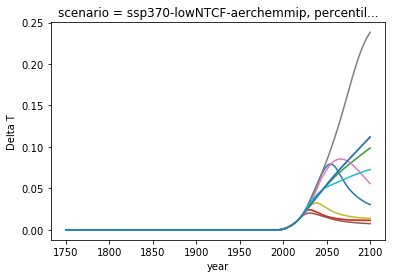

In [34]:
for scn in hfs_sum_exclusive['scenario'].values:
    hfs_sum_exclusive.sel(scenario=scn).plot()
plt.show()

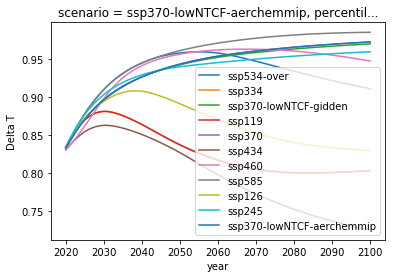

In [35]:
for scn in hfs_sum_all['scenario'].values:
    rat.sel(scenario=scn, year=slice(2020,2100)).plot(label=scn)
    #hfs_sum_all.sel(scenario=scn).plot(label=scn)
    #hfs_sum_exclusive.sel(scenario=scn).plot(label=scn)
    
plt.legend()
plt.show()

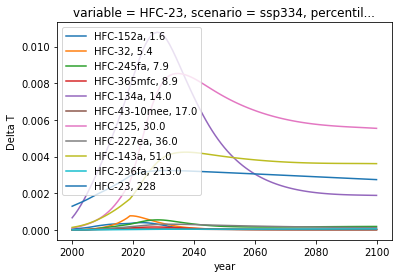

In [36]:
for hf in ordered_lifetime_ls:
    hfc_dT.sel(variable=hf, scenario='ssp334', year=slice(2000,2100)).plot(label=hf+', %s'%hfcs_tau[hf])
plt.legend()
plt.show()

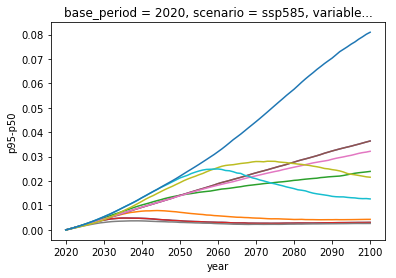

In [37]:
_da = ds_unc_upd['p95-p50'].sel(variable='HFCs')
for scn in _da['scenario'].values:
    _da.sel(scenario=scn).plot()
plt.show()

In [38]:
ds_unc_upd2 = ds_unc_upd.copy(deep=True)

In [39]:
v = 'p05-p50'
_tmp = (ds_unc_upd2[v]).loc[{'variable':'HFCs'}]*rat
ds_unc_upd2[v].loc[{'variable':'HFCs'}] =_tmp

In [40]:
v = 'p95-p50'
_tmp = (ds_unc_upd2[v]).loc[{'variable':'HFCs'}]*rat
ds_unc_upd2[v].loc[{'variable':'HFCs'}] =_tmp

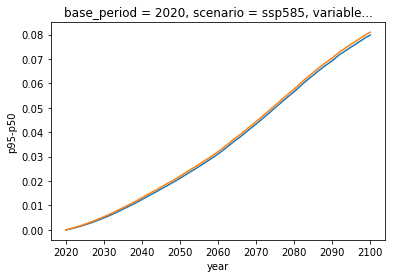

In [41]:
ds_unc_upd2[v].sel(scenario='ssp585',variable='HFCs').plot()

ds_unc_upd[v].sel(scenario='ssp585',variable='HFCs').plot()

In [42]:
ds_unc_upd2.to_netcdf(PATH_UNCERT_DT_OUTPUT)

In [43]:
print(PATH_UNCERT_DT_OUTPUT)

PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_uncertainty_data_FaIR_chris_ed02-3.nc')